<a href="https://colab.research.google.com/github/madeliefteeken/TM10007_ML_Project_G17/blob/main/MachineLearningCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


In [ ]:
# Data loading functions. Uncomment the one you want to use
# Import other classifiers you plan to use
from worclipo.load_data import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score
from scipy import stats
from sklearn.metrics import RocCurveDisplay



data = load_data()
print(f"The number of samples: {len(data.index)}")
print(f"The number of columns: {len(data.columns)}")
print(f"The number of liposarcoma in the dataset: {len(data[data['label'] == 'liposarcoma'])}")
print(f"The number of lipoma in the dataset: {len(data[data['label'] == 'lipoma'])}")

The number of samples: 115
The number of columns: 494
The number of liposarcoma in the dataset: 58
The number of lipoma in the dataset: 57


In [ ]:

# Separate features and target variable
x = data.drop(['label'], axis=1)
y = data['label']

'''deleting all the columns with 0 variance'''

for feature in x.columns:
    variance = x[feature].var()
    if variance == 0.0:
         x= x.drop(feature, axis=1)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Optionally, print the sizes of the splits to verify
print("Training set size:", x_train.shape)
print("Testing set size:", x_test.shape)


Training set size: (92, 474)
Testing set size: (23, 474)


In [ ]:
outliers_total = 0

for feature in x_train.columns:
    q1 = x_train[feature].quantile(0.25)
    q3 = x_train[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers_column = (x_train[feature] < lower_bound).sum() + (x_train[feature] > upper_bound).sum()
    outliers_total += outliers_column

    x_train.loc[x_train[feature] < lower_bound, feature] = int(lower_bound)
    x_train.loc[x_train[feature] > upper_bound, feature] = int(upper_bound)

print(f"{outliers_total} outliers were replaced.")
print(f"This was {round(outliers_total / (len(data.index) * len(data.columns)) *100)}% of the total amount of datapoints.")

2211 outliers were replaced.
This was 4% of the total amount of datapoints.


In [ ]:
def scaling_data(x_train,x_test):
    scaler = preprocessing.StandardScaler().fit(x_train)

    # Applying scaler to train and test set
    X_train_scaled = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scaling_data(x_train, x_test)


In [ ]:
'''checking if train-set is normally distributed'''
lipoma = X_train_scaled[y_train =='lipoma']
liposarcoma = X_train_scaled[y_train =='liposarcoma']
alpha = 0.05
non_gaussian_lipoma = 0
non_gaussian_liposarcoma = 0

gaussian_test_lipoma = pd.DataFrame(columns=['statistic', 'p_value'])
for feature in lipoma.columns:
    statistic, p_value = stats.shapiro(lipoma[feature])
    feature_result = pd.DataFrame({'statistic': statistic, 'p_value': p_value}, index = [feature])
    gaussian_test = pd.concat([gaussian_test_lipoma, feature_result])
    if p_value < alpha:
        non_gaussian_lipoma += 1

gaussian_test_liposarcoma = pd.DataFrame(columns=['statistic', 'p_value'])
for feature in lipoma.columns:
    statistic, p_value = stats.shapiro(liposarcoma[feature])
    feature_result = pd.DataFrame({'statistic': statistic, 'p_value': p_value}, index = [feature])
    gaussian_test = pd.concat([gaussian_test_liposarcoma, feature_result])
    if p_value < alpha:
        non_gaussian_liposarcoma += 1

print(f"{non_gaussian_lipoma} features are not gaussian distributed for lipoma")
print(f"{non_gaussian_liposarcoma} features are not gaussian distributed for liposarcoma")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input d

266 features are not gaussian distributed for lipoma
266 features are not gaussian distributed for liposarcoma


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input d

In [ ]:
def manual_feature_selection_ttest(X_train_scaled, y_train):
    '''defiition to calculate the Ttest and P-value of every feature
    input: x_train, y_train
    output: beste 5 festures'''

    lipoma = X_train_scaled[y_train =='lipoma']
    liposarcoma = X_train_scaled[y_train =='liposarcoma']

    mwu_result = pd.DataFrame(columns=['statistic', 'p_value'])
    for feature in X_train_scaled.columns:
        statistic, p_value = stats.mannwhitneyu(lipoma[feature], liposarcoma[feature])
        feature_result = pd.DataFrame({'statistic': statistic, 'p_value': p_value}, index = [feature])
        mwu_result = pd.concat([mwu_result, feature_result])
    return mwu_result

def select_features_by_p_value(mwu_result, alpha=0.05):
    '''Definition to select features based on p-value threshold of 0.05'''

    selected_features = mwu_result[mwu_result['p_value'] < alpha].index
    selected_features_df = X_train_scaled[selected_features]

    return selected_features_df

mwu_result = manual_feature_selection_ttest(X_train_scaled, y_train)
selected_features_df = select_features_by_p_value(mwu_result, alpha=0.05)

print(selected_features_df.shape)

(92, 97)


In [ ]:
def apply_pca_with_variance(X, min_variance):
    '''Definition to apply PCA for dimensionality reduction until a desired variance is achieved'''

    pca = PCA()
    X_pca = pca.fit_transform(X)
    explained_variance_ratios = pca.explained_variance_ratio_

    # Accumulate explained variances until reaching the desired threshold
    cumulative_variance_ratio = 0.0
    n_components = 0
    for variance_ratio in explained_variance_ratios:
        cumulative_variance_ratio += variance_ratio
        n_components += 1
        if cumulative_variance_ratio >= min_variance:
            break

    # Fit PCA again with the selected number of components
    pca = PCA(n_components=n_components)
    pca.fit_transform(X)
    X_pca = pca.fit_transform(X)
    X_pca_df = pd.DataFrame(X_pca)

    print(X_pca_df.shape)

    # Print the total explained variance ratio and the number of components
    print("Total explained variance ratio:", cumulative_variance_ratio)
    print("Number of components:", n_components)

    # Obtain eigenvalues
    eigenvalues = pca.explained_variance_
    print("Eigenvalues:", eigenvalues)
    return X_pca_df, pca

min_variance_ratio = 0.87  # 89% of the total explained variance ratio
X_pca_df, pca = apply_pca_with_variance(selected_features_df, min_variance_ratio)

(92, 16)
Total explained variance ratio: 0.874362002227483
Number of components: 16
Eigenvalues: [42.51029091 11.59627387  5.45780131  3.43984148  3.21705657  2.98259128
  2.70427343  2.21555012  1.99302928  1.73500506  1.65053861  1.55020541
  1.39292839  1.24967963  1.033373    1.01668812]


In [ ]:
# Fit LabelEncoder and transform the predicted string labels to numerical labels
label_encoder = LabelEncoder()
y_train_numerical = label_encoder.fit_transform(y_train)

kfold = KFold(n_splits=12, shuffle=True, random_state=42)

clf_rfc = RandomForestClassifier(random_state=10)
param_grid = {
    'n_estimators': range(10, 511, 100),  # Number of trees in the forest
    'max_depth': range(1,51,10),      # Maximum depth of the trees
    'min_samples_split': range(2,11,4),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': range(1,14,4)}  # Minimum number of samples required to be at a leaf node

grid_search = GridSearchCV(estimator=clf_rfc, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train_numerical)

# Get the best hyperparameters
best_estimator_rfc = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best f1 score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(best_estimator_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(best_estimator_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(best_estimator_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(best_estimator_rfc, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 110}
Best f1 score: 0.7708273208273207
accuracy: 0.7559523809523809
precision: 0.7527777777777778
recall: 0.8305555555555556
F1-score: 0.7708273208273207


In [ ]:
clf_svm = SVC()

param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear', 'poly'],
              'degree': [1, 3, 5]}

grid_search = GridSearchCV(estimator=clf_svm, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train_numerical)

# Get the best hyperparameters
best_estimator_svm = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best f1 score: {grid_search.best_score_}")


# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(best_estimator_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(best_estimator_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(best_estimator_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(best_estimator_svm, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Best f1 score: 0.7856120731120732
accuracy: 0.8080357142857143
precision: 0.8388888888888889
recall: 0.8027777777777777
F1-score: 0.7856120731120732


In [ ]:
clf_knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}  # 1 for Manhattan distance, 2 for Euclidean distance

grid_search = GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train_numerical)

# Get the best hyperparameters
best_estimator_knn = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best f1 score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(best_estimator_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(best_estimator_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(best_estimator_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(best_estimator_knn, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best f1 score: 0.7011784511784512
accuracy: 0.6964285714285715
precision: 0.7166666666666667
recall: 0.7680555555555556
F1-score: 0.7011784511784512


In [ ]:
clf_dt = DecisionTreeClassifier(random_state=10)

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': [None, 'sqrt', 'log2']}

grid_search = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv=kfold, scoring = 'f1', n_jobs=-1)
grid_search.fit(X_pca_df, y_train_numerical)

# Get the best hyperparameters
best_estimator_dt = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best f1 score: {grid_search.best_score_}")

# Voer cross-validation uit en bereken scores voor elke fold
accuracy_scores = cross_val_score(best_estimator_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(accuracy_score))
precision_scores = cross_val_score(best_estimator_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(precision_score))
recall_scores = cross_val_score(best_estimator_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(recall_score))
f1_scores = cross_val_score(best_estimator_dt, X_pca_df, y_train_numerical, cv=kfold, scoring=make_scorer(f1_score))

# Bereken de gemiddelde scores
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print("accuracy:", mean_accuracy)
print("precision:", mean_precision)
print("recall:", mean_recall)
print("F1-score:", mean_f1)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best f1 score: 0.7264971139971141
accuracy: 0.6994047619047619
precision: 0.7281746031746031
recall: 0.7819444444444444
F1-score: 0.7264971139971141


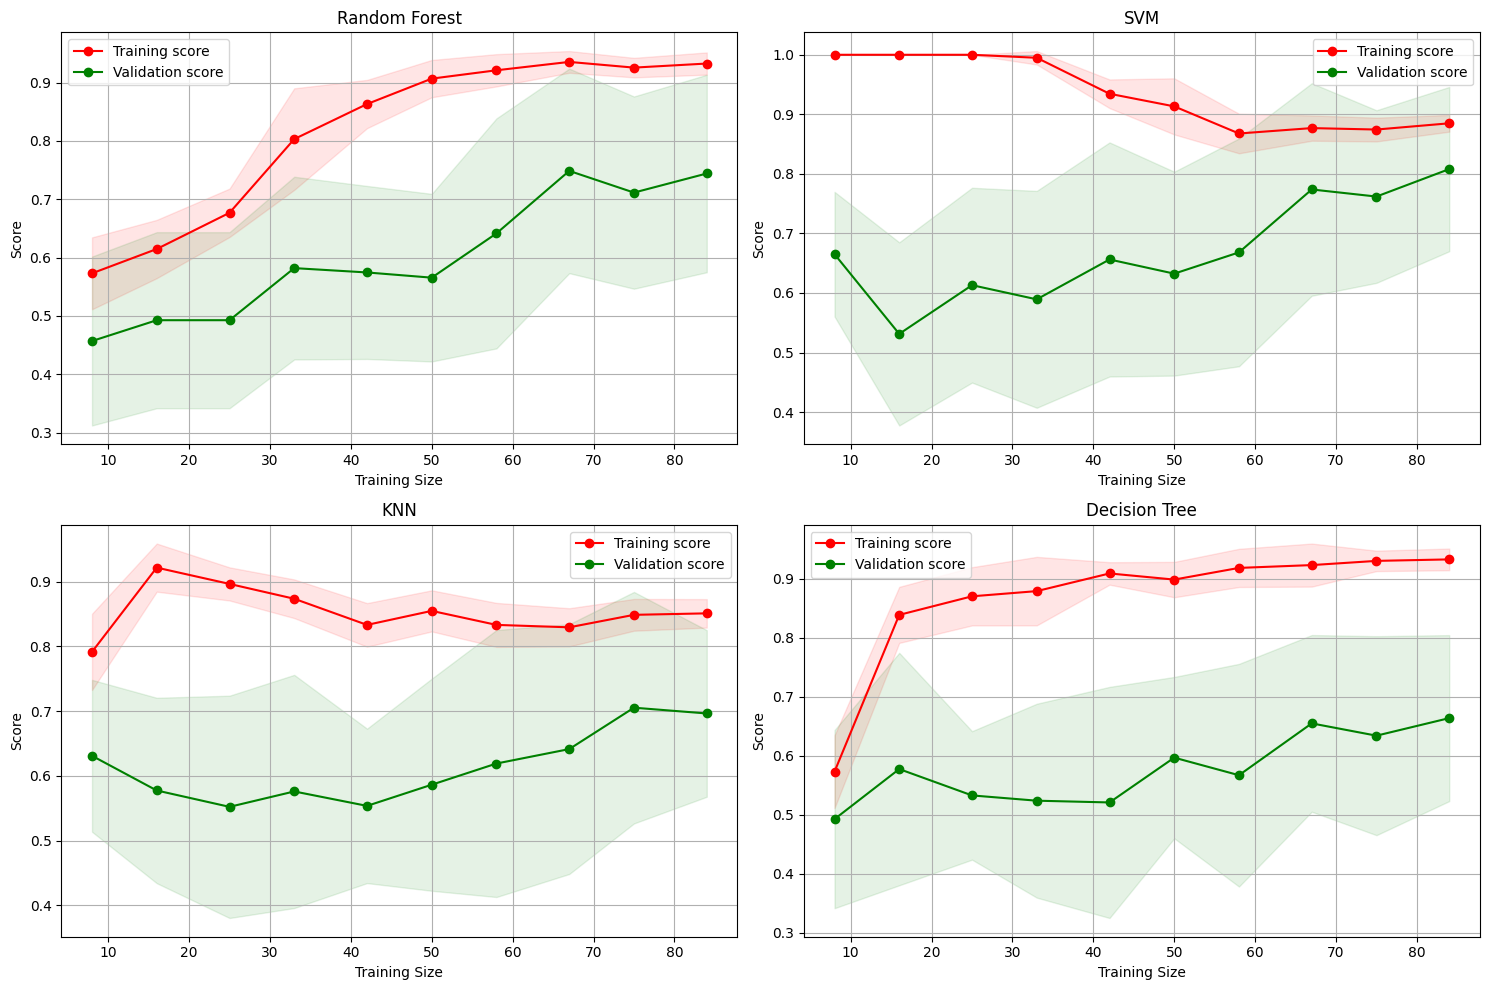

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curves_for_multiple_models(models, names, X, y, cv=kfold, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots learning curves for multiple models in a single figure with subplots.

    Parameters:
    - models: List of sklearn model instances.
    - names: List of model names as strings for titles.
    - X: Features matrix.
    - y: Target vector.
    - cv: Number of cross-validation folds.
    - n_jobs: Number of jobs to run in parallel (-1 means using all processors).
    - train_sizes: Fraction of the dataset to generate learning curves.
    """

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for ax, model, name in zip(axes, models, names):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

        ax.set_title(name)
        ax.set_xlabel('Training Size')
        ax.set_ylabel('Score')
        ax.legend(loc="best")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

models = [best_estimator_rfc, best_estimator_svm, best_estimator_knn, best_estimator_dt]
names = ["Random Forest", "SVM", "KNN", "Decision Tree"]
plot_learning_curves_for_multiple_models(models, names, X_pca_df, y_train, cv=kfold, n_jobs=None)

In [ ]:
X_test_features = X_test_scaled[selected_features_df.columns]

X_test_pca = pca.transform(X_test_features)
y_test_numerical = label_encoder.fit_transform(y_test)


rfc_prediction = best_estimator_rfc.predict(X_test_pca)

accuracy = accuracy_score(y_test_numerical, rfc_prediction)
print('Accuracy score on the test set: %.2f%%' % (accuracy*100))
f1 = f1_score(y_test_numerical, rfc_prediction, pos_label=1)
print('F1-score score on the test set: %.2f%%' % (f1*100))
recall = recall_score(y_test_numerical, rfc_prediction, pos_label=1)
print('Recall score on the test set: %.2f%%' % (recall*100))
precision = precision_score(y_test_numerical, rfc_prediction, pos_label=1)
print('Precision score on the test set: %.2f%%' % (precision*100))

tn, fp, fn, tp = confusion_matrix(y_test_numerical,rfc_prediction).ravel()
sens = tp/(tp+fn)
print('Sensitivity score on the test set: %.2f%%' % (sens*100))
spec = tn/(tn+fp)
print('Specificity score on the test set: %.2f%%' % (spec*100))



Accuracy score on the test set: 73.91%
F1-score score on the test set: 72.73%
Recall score on the test set: 72.73%
Precision score on the test set: 72.73%
Sensitivity score on the test set: 72.73%
Specificity score on the test set: 75.00%


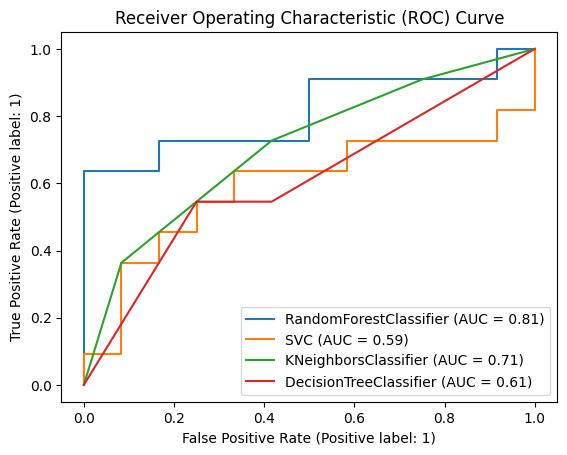

In [ ]:
ax = plt.gca()
for model in models:
    rfc_roc = RocCurveDisplay.from_estimator(model, X_test_pca, y_test_numerical, ax=ax, pos_label=1)

handles, labels = ax.get_legend_handles_labels()
#new_labels = ['liposarcoma', 'lipoma']  # Volgorde van de labels is [pos_label, neg_label]
#ax.legend(handles, new_labels, loc='lower right')  # Pas loc aan indien nodig

plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.show()